In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [2]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import fits_to_pandas, pandas_to_fits, assess_goodnes_of_cross_match, rayleigh_plot, desi_reliable_magnitudes
import pandas as pd
import numpy as np
import seaborn as sns
import nway_python_api as nway
set_mpl()
%matplotlib inline

matplotlib settings set


matplotlib settings set
This is NWAY Python API
nwaylib file /Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py
matplotlib settings set


In [3]:
desi_pandas_ph =  pd.read_pickle(data_path+'desi_lh.gz_pkl', compression = 'gzip')
desi_pandas_ph.columns = ['desi_'+x for x in desi_pandas_ph.columns]
desi_pandas_ph.rename(columns={'desi_desi_id':'nway_desi_id'}, inplace=True)


erosita_orig_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')
#set EROSITA as an index
erosita_orig_df['EROSITA'] = erosita_orig_df.index

In [4]:
ero_pandas = fits_to_pandas('ERO_lhpv_03_23_sd01_a15_g14.fits') #this catalog is used for nway cross-matching
ero_ctps_pandas = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
ero_pandas = ero_pandas.merge(ero_ctps_pandas, on='ID', how='left')

nway_res = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_nway.pkl')
nway_res_dist_only = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_nway_distance_only.pkl')


In [5]:
ero_ctps_pandas[ero_ctps_pandas.desi_id_true_ctp!=b'hostless']

,ID,desi_id_true_ctp
0,b'SRGe J103105.9+573747',b'9011_610714_1440'
1,b'SRGe J103123.8+574309',b'9011_610714_2092'
2,b'SRGe J103130.8+573932',b'9011_610714_2412'
3,b'SRGe J103137.0+573159',b'9011_609939_1093'
4,b'SRGe J103143.5+573156',b'9011_609939_1343'
...,...,...
676,b'SRGe J110614.9+585347',b'9011_614527_601'
677,b'SRGe J110633.0+590313',b'9011_614527_1198'
678,b'SRGe J110645.0+590331',b'9011_614527_1596'
679,b'SRGe J110648.4+585514',b'9011_614527_1704'


In [6]:
def get_flag_num(x, flag):
    try:
        return x.value_counts()[flag]
    except:
        return 0

nway_res['n_match_flag_0'] = nway_res.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 0))
nway_res['n_match_flag_2'] = nway_res.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 2))
tmp = nway_res.groupby('EROSITA')['Separation_EROSITA_DESI'].transform(lambda x: min(x))
nway_res['is_closest'] = tmp == nway_res['Separation_EROSITA_DESI']
nway_res['is_within_pos_r98'] = nway_res['Separation_EROSITA_DESI'] < 2.79*nway_res['pos_err']/0.9 #2.79 if the coeff to transform pos_sigma2d (0.39 prob) into pos_r98 (0.98 prob) via  [0.98 = 1 - exp(-r^2/2) solve for r]. Assuming pos_err is the standard deviation of the position error (sigma 2d, 39% probability). factor 1//0.9 is to take into account the positional error used in NWAY (Which is 0.9*pos_sigma_2d). 




nway_res_dist_only['n_match_flag_0'] = nway_res_dist_only.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 0))
nway_res_dist_only['n_match_flag_2'] = nway_res_dist_only.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 2))
tmp = nway_res_dist_only.groupby('EROSITA')['Separation_EROSITA_DESI'].transform(lambda x: min(x))
nway_res_dist_only['is_closest'] = tmp == nway_res_dist_only['Separation_EROSITA_DESI']
nway_res_dist_only['is_within_pos_r98'] = nway_res_dist_only['Separation_EROSITA_DESI'] < 2.79*nway_res_dist_only['pos_err'] 


In [7]:
print(nway_res.query('match_flag == 1').groupby('is_closest')['is_within_pos_r98'].value_counts())
print(nway_res_dist_only.query('match_flag == 1').groupby('is_closest')['is_within_pos_r98'].value_counts())

is_closest  is_within_pos_r98
False       True                 1439
            False                 145
True        True                 7201
            False                 430
Name: is_within_pos_r98, dtype: int64
is_closest  is_within_pos_r98
True        True                 8506
            False                 709
Name: is_within_pos_r98, dtype: int64


# Completeness/purity analysis

In [8]:
print(nway_res.query('desi_id == desi_id_true_ctp & is_within_pos_r98 == 1').is_closest.value_counts())


True     513
False     73
Name: is_closest, dtype: int64


In [9]:
print('not hostless validation only')
print('correct match + within r98: is_closest or not')
print(nway_res.query('desi_id_true_ctp!="hostless" & match_flag==1 & desi_id==desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 1').is_closest.value_counts())
print('incorrect  match + within r98: is_closest or not')
print(nway_res.query('desi_id_true_ctp!="hostless" & match_flag==1 & desi_id!=desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 1').is_closest.value_counts())
print('correct match + outside r98: is_closest or not')
print(nway_res.query('desi_id_true_ctp!="hostless" & match_flag==1 & desi_id==desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 0').is_closest.value_counts())
print('incorrect match + outside r98: is_closest or not')
print(nway_res.query('desi_id_true_ctp!="hostless" & match_flag==1 & desi_id!=desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 0').is_closest.value_counts())

not hostless validation only
correct match + within r98: is_closest or not
True     509
False     53
Name: is_closest, dtype: int64
incorrect  match + within r98: is_closest or not
True     47
False     9
Name: is_closest, dtype: int64
correct match + outside r98: is_closest or not
False    3
True     2
Name: is_closest, dtype: int64
incorrect match + outside r98: is_closest or not
True     18
False     5
Name: is_closest, dtype: int64


matplotlib settings set
 NOT HOSTLESS 
assigned NOT HOSTLESS: 572
assigned NOT HOSTLESS with correct match: 548
total: 597
purity [assigned NOT HOSTLESS correctly / all NOT HOSTLESS]: 0.958041958041958
completeness [all NOT HOSTLESS / total NOT HOSTLESS]: 0.9581239530988275
 HOSTLESS 
assigned HOSTLESS: 39
assigned HOSTLESS correctly: 39
total HOSTLESS: 49
purity [assigned HOSTLESS correctly / all assigned HOSTLESS]: 1.0
completeness [all HOSTLESS assigned / total HOSTLESS]: 0.7959183673469388
 NOT HOSTLESS 
assigned NOT HOSTLESS: 520
assigned NOT HOSTLESS with correct match: 452
total: 597
purity [assigned NOT HOSTLESS correctly / all NOT HOSTLESS]: 0.8692307692307693
completeness [all NOT HOSTLESS / total NOT HOSTLESS]: 0.8710217755443886
 HOSTLESS 
assigned HOSTLESS: 41
assigned HOSTLESS correctly: 41
total HOSTLESS: 49
purity [assigned HOSTLESS correctly / all assigned HOSTLESS]: 1.0
completeness [all HOSTLESS assigned / total HOSTLESS]: 0.8367346938775511
 NOT HOSTLESS 
assigned N

Text(0.5, 0.98, 'XMM/CHANDRA Lockman Hole validation catalog')

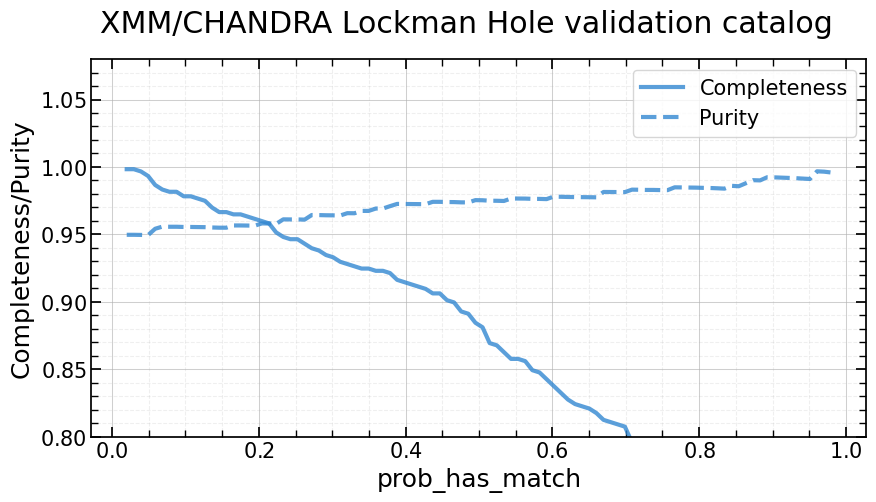

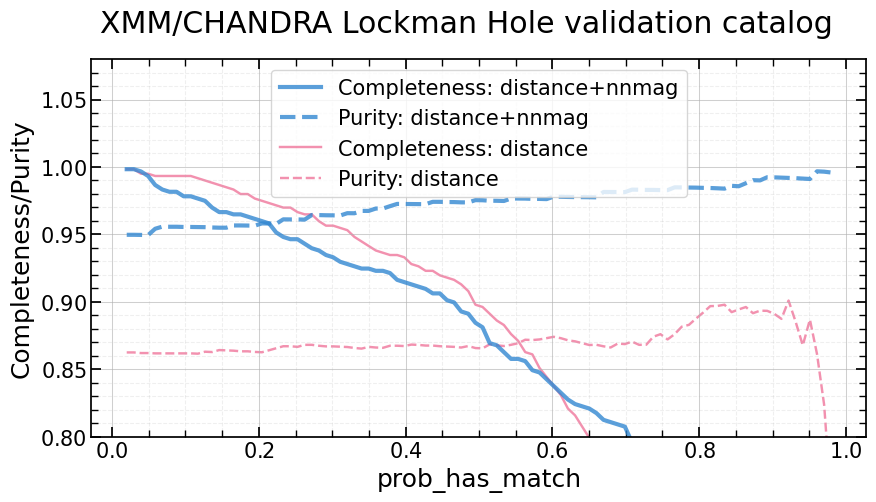

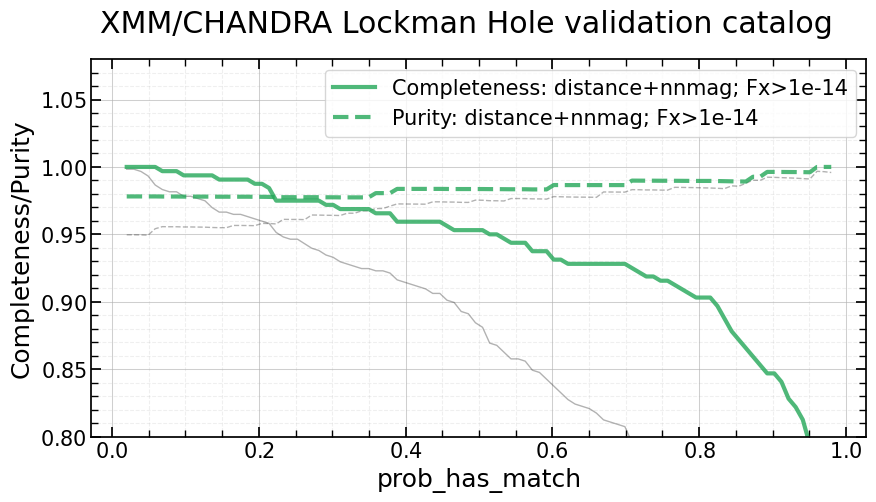

In [10]:
set_mpl()
cutoffs_nnmag, completeness_nnmag, purity_nnmag , _, _, _= assess_goodnes_of_cross_match(nway_res, plot_res=False)

cutoffs_dist_only, completeness_dist_only, purity_dist_only , _, _, _= assess_goodnes_of_cross_match(nway_res_dist_only, plot_res=False)



plt.figure(figsize=(10,5))

plt.plot(cutoffs_nnmag, completeness_nnmag, 'C0-', lw = 3, alpha = 0.8, label=f'Completeness')
plt.plot(cutoffs_nnmag, purity_nnmag, 'C0--', lw = 3,  alpha = 0.8, label=f'Purity')

plt.legend()
plt.ylim(0.8,1.08)
plt.xlabel('prob_has_match')
plt.grid(visible=True, which='major', linestyle='-', alpha = 0.6)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.2)
plt.ylabel('Completeness/Purity')
plt.suptitle('XMM/CHANDRA Lockman Hole validation catalog')


plt.figure(figsize=(10,5))

plt.plot(cutoffs_nnmag, completeness_nnmag, 'C0-', lw = 3, alpha = 0.8, label=f'Completeness: distance+nnmag')
plt.plot(cutoffs_nnmag, purity_nnmag, 'C0--', lw = 3,  alpha = 0.8, label=f'Purity: distance+nnmag')

plt.plot(cutoffs_dist_only, completeness_dist_only, 'C1-', alpha = 0.5, label=f'Completeness: distance', zorder = -1)
plt.plot(cutoffs_dist_only, purity_dist_only, 'C1--', alpha = 0.5, label=f'Purity: distance', zorder = -1)

plt.legend()
plt.ylim(0.8,1.08)
plt.xlabel('prob_has_match')
plt.grid(visible=True, which='major', linestyle='-', alpha = 0.6)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.2)
plt.ylabel('Completeness/Purity')
plt.suptitle('XMM/CHANDRA Lockman Hole validation catalog')



plt.figure(figsize=(10,5))


#cutoff_intersection_nnmag_bright, completeness_intersection_nnmag_bright,  cutoffs_nnmag_bright, completeness_nnmag_bright, purity_nnmag_bright = assess_goodnes_nway_cross_match(nway_res[nway_res.ML_FLUX_0>1e-14], plot_res=False)

cutoffs_nnmag_bright, completeness_nnmag_bright, purity_nnmag_bright , _, _, _= assess_goodnes_of_cross_match(nway_res.query('ML_FLUX_0>1e-14'), plot_res=False)



plt.plot(cutoffs_nnmag, completeness_nnmag, 'k-', lw = 1, alpha = 0.3, label=f'_Completeness: distance+nnmag')
plt.plot(cutoffs_nnmag, purity_nnmag, 'k--', lw = 1,  alpha = 0.3, label=f'_Purity: distance+nnmag')


plt.plot(cutoffs_nnmag_bright, completeness_nnmag_bright, 'C2-', lw = 3, alpha = 0.8, label=f'Completeness: distance+nnmag; Fx>1e-14')
plt.plot(cutoffs_nnmag_bright, purity_nnmag_bright, 'C2--', lw = 3,  alpha = 0.8, label=f'Purity: distance+nnmag; Fx>1e-14')

plt.legend()
plt.ylim(0.8,1.08)
plt.xlabel('prob_has_match')
plt.grid(visible=True, which='major', linestyle='-', alpha = 0.6)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.2)
plt.ylabel('Completeness/Purity')
plt.suptitle('XMM/CHANDRA Lockman Hole validation catalog')


# Distribution of `p_any` for different groups

In [11]:
nway_res.query('desi_id_true_ctp==b"hostless"').prob_has_match

29448     0.094352
29447     0.094352
29442     0.094352
29446     0.094352
29439     0.094352
            ...   
134031    0.340292
134037    0.340292
134039    0.340292
134034    0.340292
134029    0.340292
Name: prob_has_match, Length: 622, dtype: float64

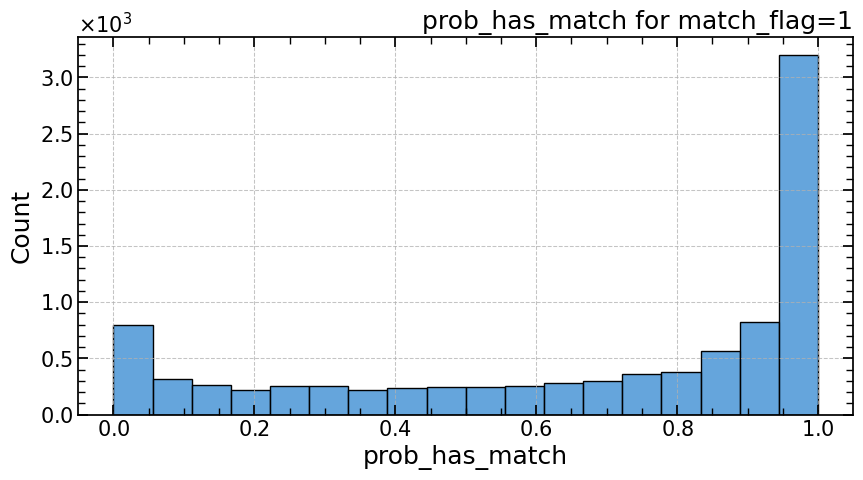

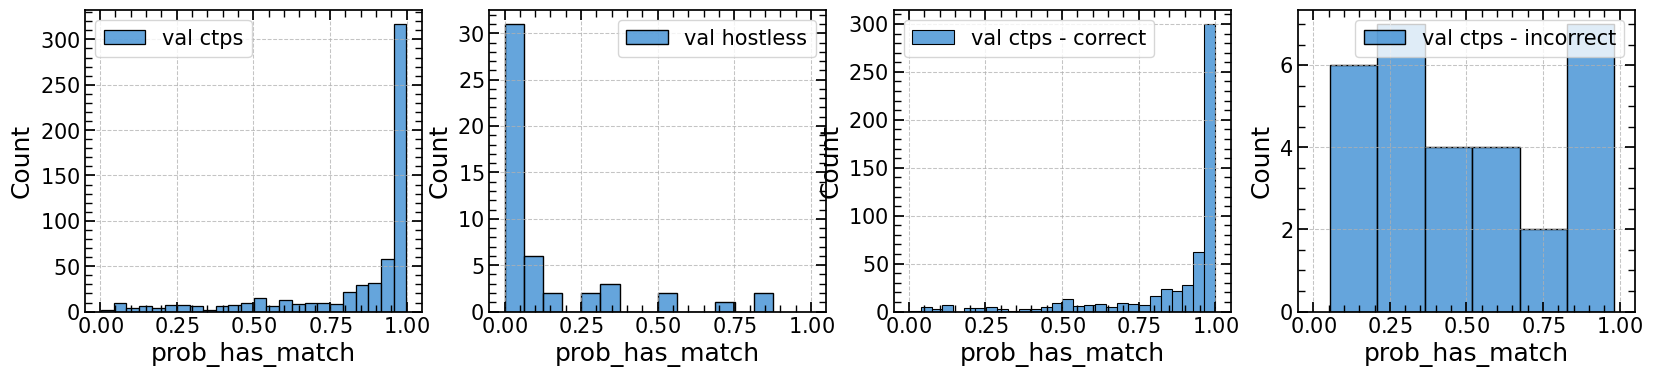

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(nway_res.query('match_flag==1').prob_has_match)
plt.title('prob_has_match for match_flag=1', loc = 'right')


fig, axs =  plt.subplots(nrows=1, ncols = 4, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': None}, figsize = (20,4))

sns.histplot(nway_res.query('match_flag==1 & ~desi_id_true_ctp.isna() & desi_id_true_ctp!=b"hostless"').prob_has_match, ax = axs[0], label = 'val ctps')
axs[0].legend()


sns.histplot(nway_res.query('match_flag==1 & ~desi_id_true_ctp.isna() & desi_id_true_ctp==b"hostless"').prob_has_match, ax = axs[1], label = 'val hostless')
axs[1].legend()


sns.histplot(nway_res.query('match_flag==1 & ~desi_id_true_ctp.isna() & desi_id_true_ctp==desi_id & desi_id_true_ctp!=b"hostless"').prob_has_match, ax = axs[2], label = 'val ctps - correct')
axs[2].legend()

sns.histplot(nway_res.query('match_flag==1 & ~desi_id_true_ctp.isna() & desi_id_true_ctp!=desi_id & desi_id_true_ctp!=b"hostless"').prob_has_match, ax = axs[3], label = 'val ctps - incorrect')
axs[3].legend()

# Distribution of nnmags for good matches with validation catalog

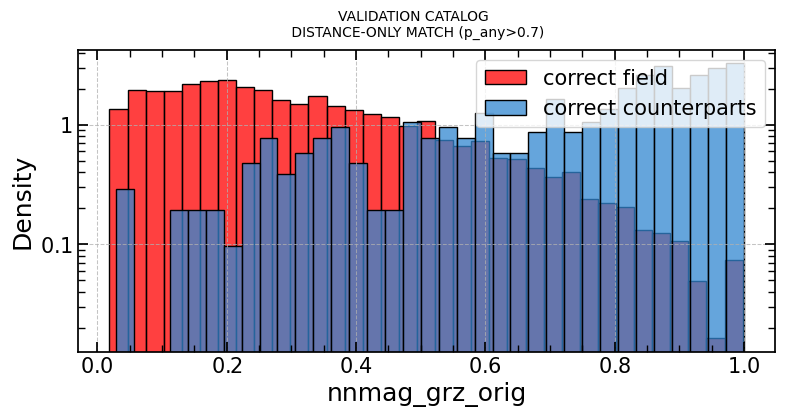

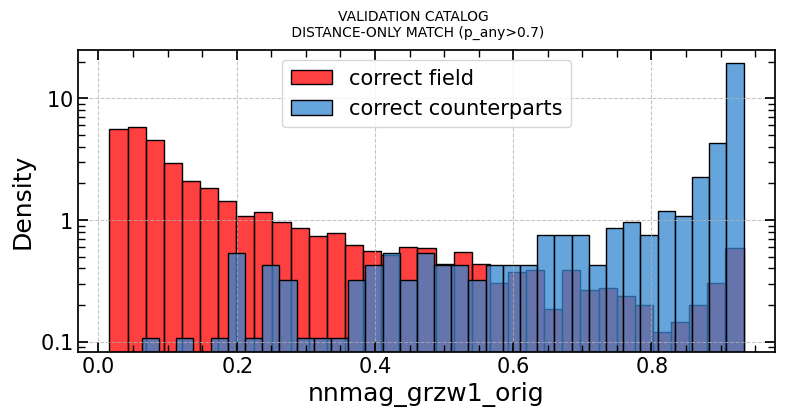

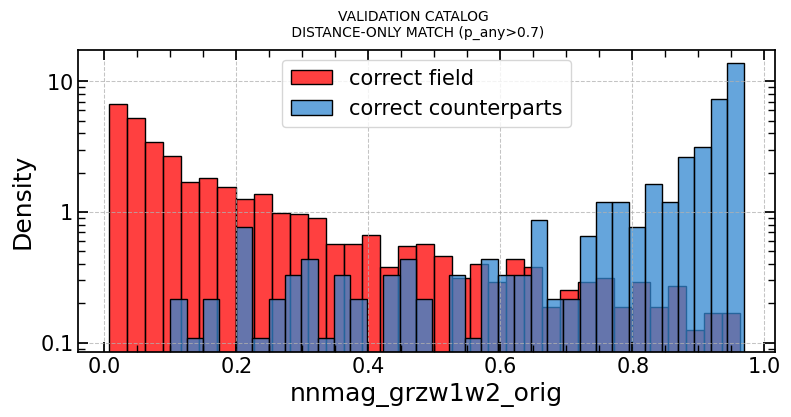

In [13]:
for prior_type in ['grz_orig', 'grzw1_orig', 'grzw1w2_orig']:
    prob_cutoff = 0.7
    plt.figure(figsize=(9,4))
    sns.histplot(nway_res_dist_only.query(f"prob_has_match>@prob_cutoff & match_flag==0 & nnmag_{prior_type}!=-99. & ~desi_id_true_ctp.isnull()")['nnmag_'+prior_type], stat = 'density', color = 'r', bins = 35, label = 'correct field')
    sns.histplot(nway_res_dist_only.query(f"prob_has_match>@prob_cutoff & match_flag==1 & nnmag_{prior_type}!=-99. & desi_id==desi_id_true_ctp")['nnmag_'+prior_type], stat = 'density', bins = 35, label = 'correct counterparts')
    plt.suptitle(f'VALIDATION CATALOG \n DISTANCE-ONLY MATCH (p_any>{prob_cutoff})', fontsize = 10)
    plt.yscale('log')
    plt.legend()

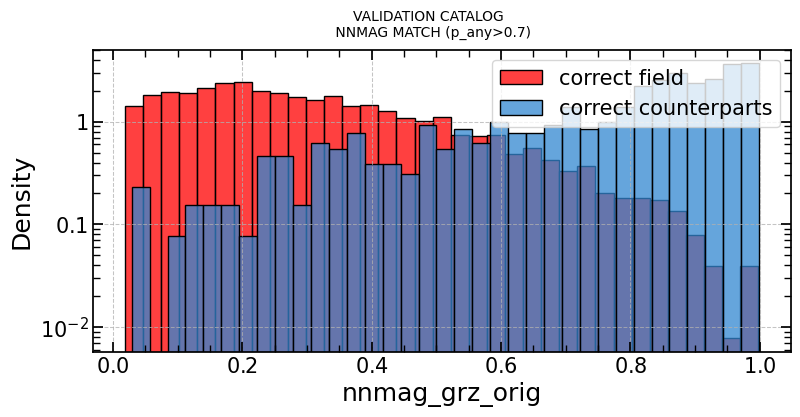

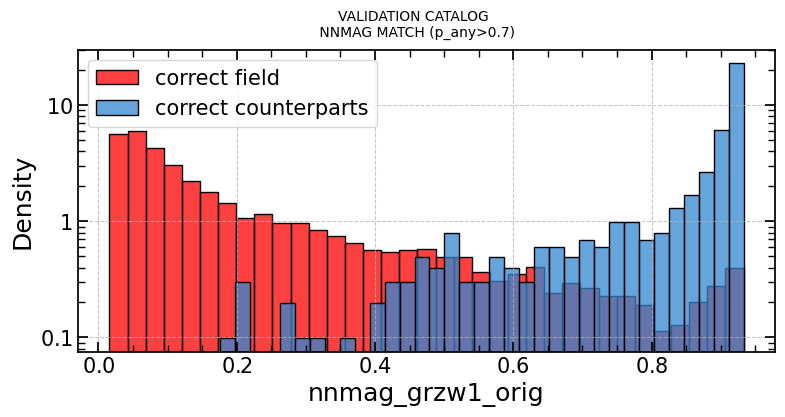

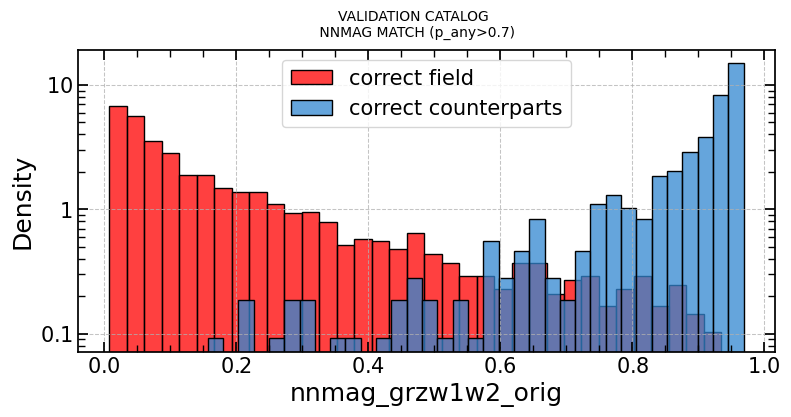

In [14]:
for prior_type in ['grz_orig', 'grzw1_orig', 'grzw1w2_orig']:
    prob_cutoff = 0.7
    plt.figure(figsize=(9,4))
    sns.histplot(nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==0 & nnmag_{prior_type}!=-99. & ~desi_id_true_ctp.isnull()")['nnmag_'+prior_type], stat = 'density', color = 'r', bins = 35, label = 'correct field')
    sns.histplot(nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==1 & nnmag_{prior_type}!=-99. & desi_id==desi_id_true_ctp")['nnmag_'+prior_type], stat = 'density', bins = 35, label = 'correct counterparts')
    plt.suptitle(f'VALIDATION CATALOG \n NNMAG MATCH (p_any>{prob_cutoff})', fontsize = 10)
    plt.yscale('log')
    plt.legend()

# Offset between secure DESI matches and eROSITA sources

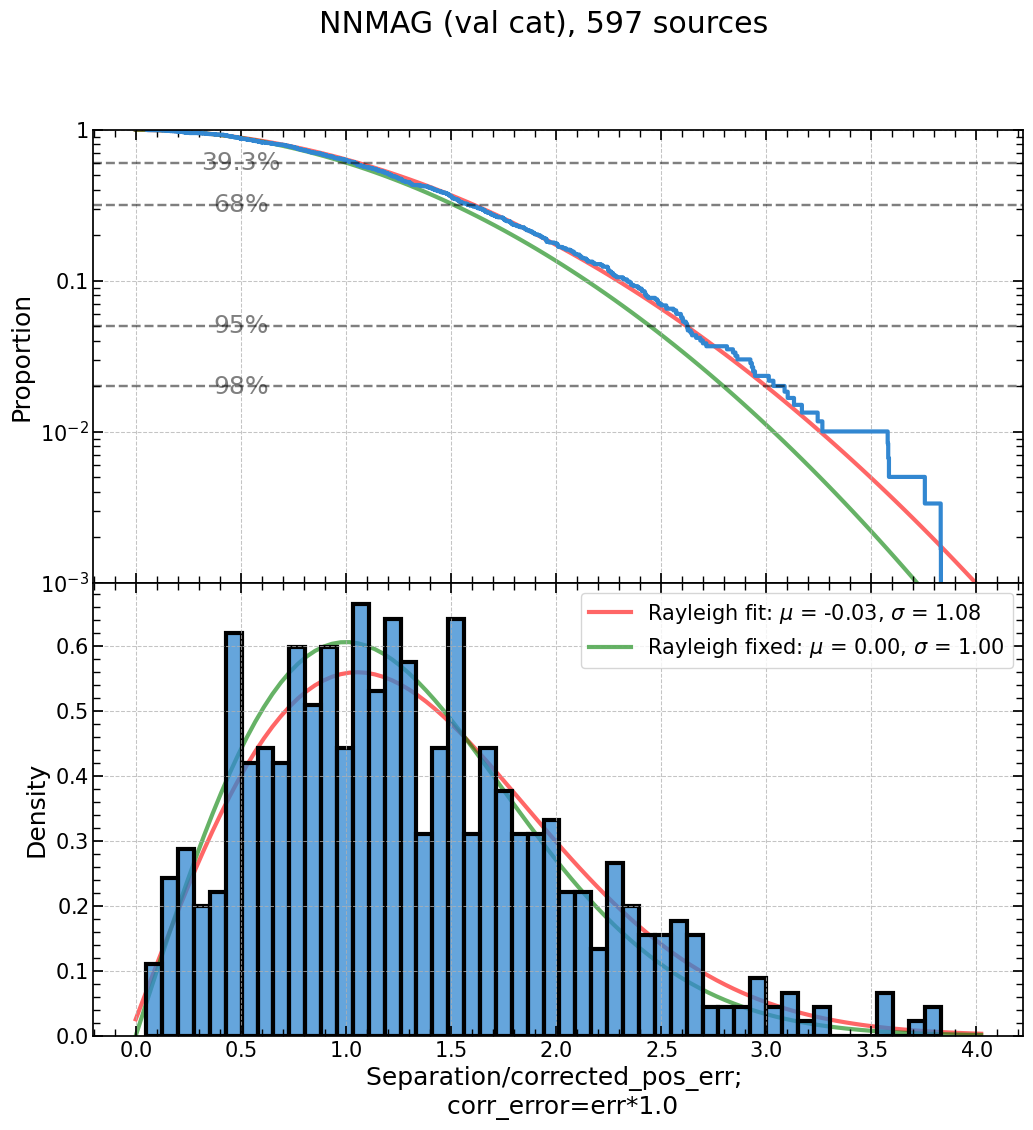

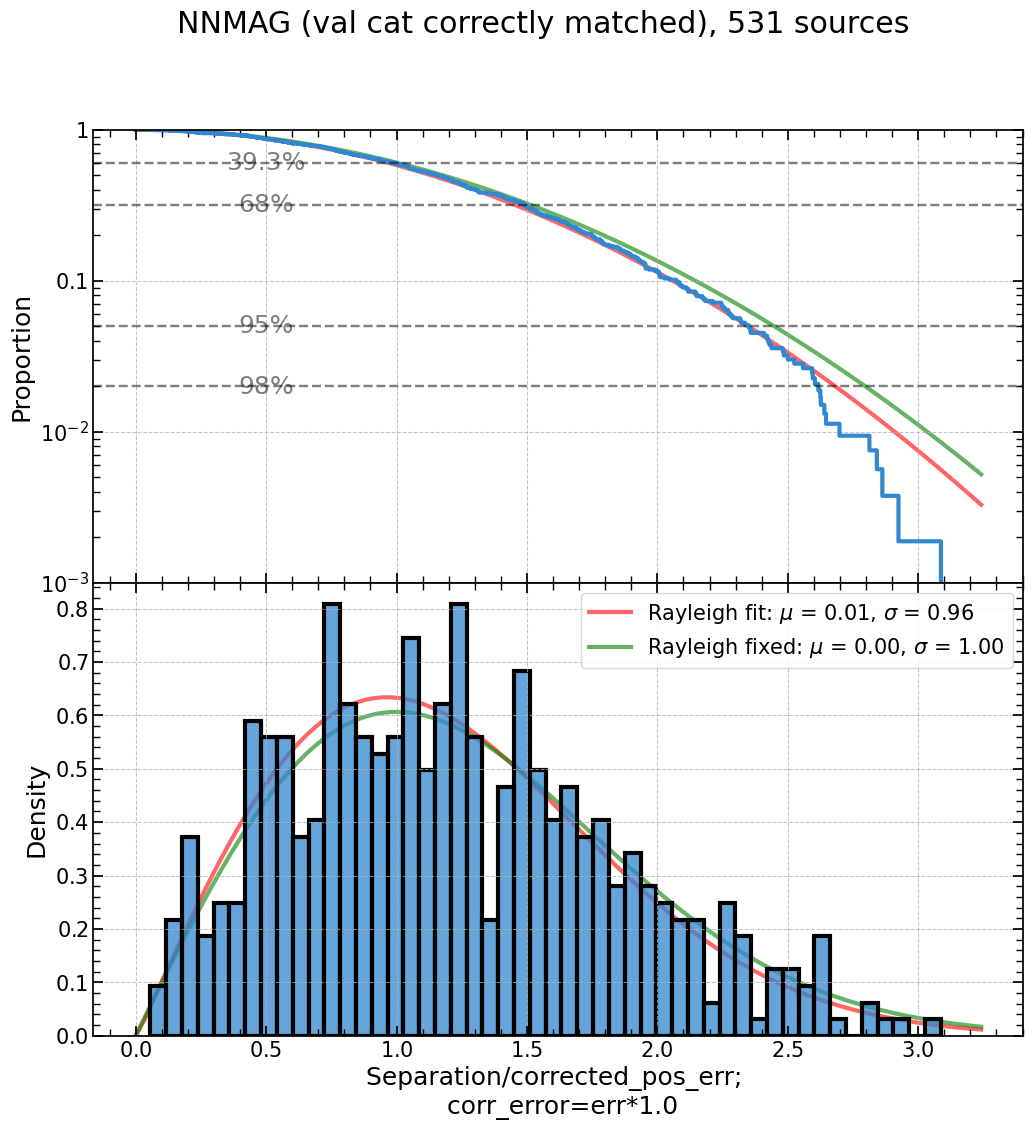

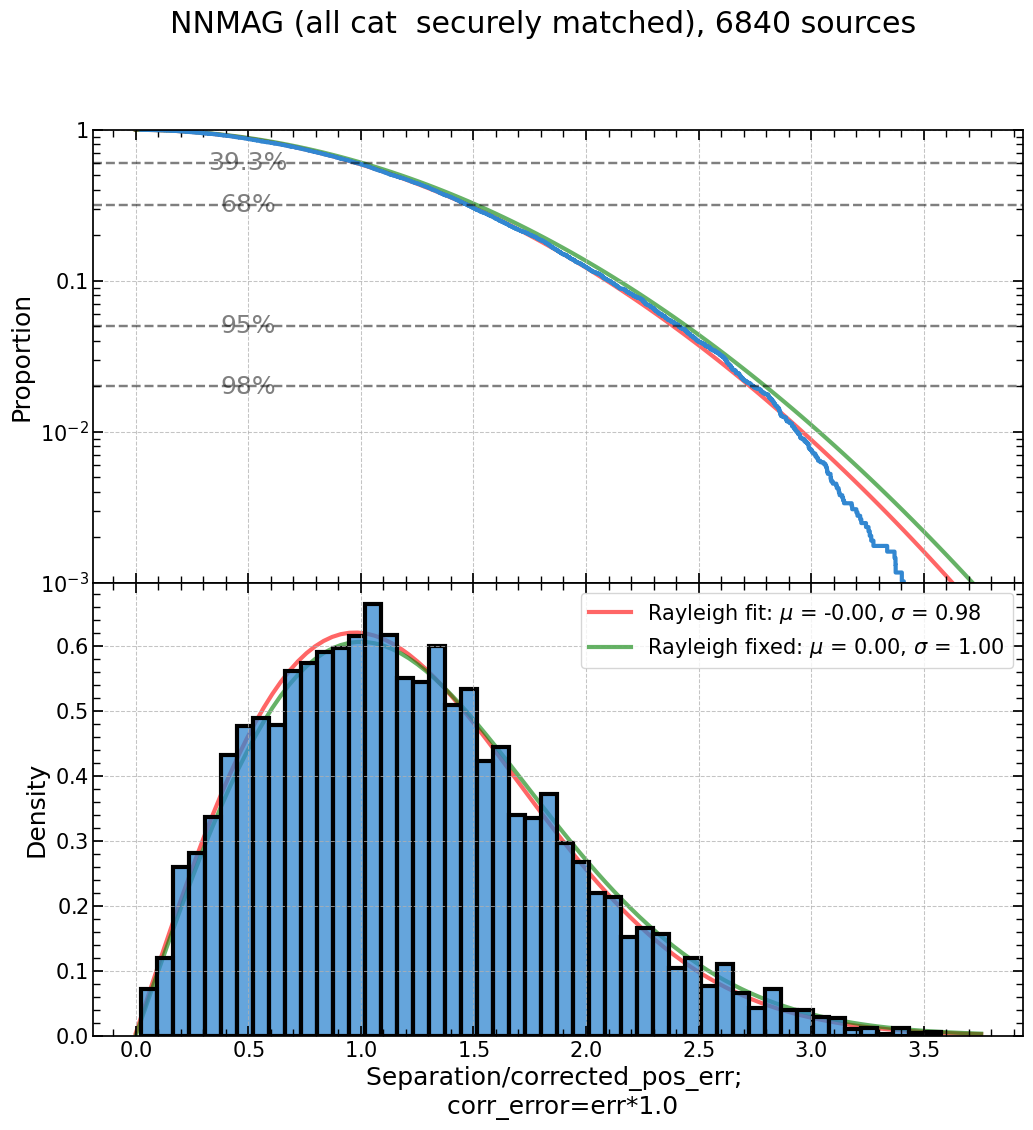

In [15]:

rayleigh_plot(nway_res.query('desi_id==desi_id_true_ctp & desi_id_true_ctp!="hostless"'), sep_col='Separation_EROSITA_DESI', pos_err_col = 'pos_err', plotlabel='NNMAG (val cat)')

rayleigh_plot(nway_res.query('match_flag==1 & desi_id==desi_id_true_ctp & desi_id_true_ctp!="hostless" & prob_has_match > 0.4'), sep_col='Separation_EROSITA_DESI', pos_err_col = 'pos_err', plotlabel='NNMAG (val cat correctly matched)')


rayleigh_plot(nway_res.query('match_flag==1  & desi_id_true_ctp!="hostless" & prob_has_match > 0.4'), sep_col='Separation_EROSITA_DESI', pos_err_col = 'pos_err', plotlabel='NNMAG (all cat  securely matched)')


# Catalog of best matches

`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_all_candidates.gz_pkl` - all possible matches for a given `srcname_fin`, i.e. a few DESI objects per eROSITA object. 


`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match.pkl` - catalog of the most-probable matches, i.e. one DESI object per eROSITA object. The first file is found as a query `match_flag==1` on `ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_all_candidates` catalog.  Another addition for this catalog is that the counterparts are always correct if the true counterpart is known from the validation catalog.



`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_dist_only.pkl` - the same as `ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match.pkl`, but only astrometric information is used to determine the counterparts probabilities.


**Description**:


170 columns


X-ray data:
* columns from `srcname_fin` to `NH` - original columns of Lockman Hole eROSITA catalog

Cross-match results:

* `nway_desi_id` - DESI candidate counterpart. `desi_id` is a concatenation of `release`, `brick` and `objid` of the DESI catalog.
* `nway_desi_id_true_ctp` - True DESI counterpart id if it is known from validation catalog. It is available for  approximately 600-700 sources eROSITA sources. Includes  hostless sources.  **Warning**: not all best matches  have `nway_desi_id` == `nway_desi_id_true_ctp` since the NWAY is not perfect.  
* `nway_Separation_EROSITA_DESI` - separation between `nway_desi_id` and eROSITA source `srcname_fin`.
* `nway_pos_err` - positional error used by Nway, it is `factor*pos_sigma_2d` from the eROSITA catalog. Factor is `1` or close to `1`. In the current version - `0.9`.  
* `nway_prob_has_match` - Nway probability of having a match in any of candidate counterparts. Generally, if `nway_prob_has_match`>~0.8, the match is secure, and if `nway_prob_has_match`<~0.2, the match is not secure.
* `nway_prob_this_match` - assuming that eROSITA source has a match, this is the probability of this particular DESI source being a counterpart. 
* `nway_nnmag_grz(w1w2)` - Magnitude of Neural network photometric classifier. The largre the number, the more likely the source is a counterpart to a generic X-ray source.
* `nway_match_flag` - flag indicating whether the source is a primary match (the largest `nway_prob_this_match`, `nway_match_flag=1`), a secondary match (`nway_prob_this_match`/`nway_prob_this_match(best match)>0.5`, `nway_match_flag=2`) or a low-probabbility match (`nway_prob_this_match`/`nway_prob_this_match(best match)<0.5`, `nway_match_flag=0`).
* `nway_n_match_flag_0` - number of DESI sources inside 30 arcsec radius of the eROSITA source which are `nway_match_flag==0`.
* `nway_n_match_flag_2` - the same as `nway_n_match_flag_0` but for `nway_match_flag==2`.
* `nway_is_closest` - True if the DESI candidate counterpart is the closest to the eROSITA source.
* `nway_is_within_pos_r98` - True if the DESI candidate counterpart is within the position error `pos_r98` of the eROSITA source.
* `nway_closest_is_psf` - True if the closest DESI candidate counterpart has a type `PSF`. It may be useful to diagnose if the closest counterpart is not a point source, but a galaxy or any extended source. 

Optical data:
* columns from `desi_release` onwards are the columns of the DESI catalog for a `nway_desi_id`. Some columns are produced by a SB's function `desi_reliable_magnitudes`.




Only reliable (SN>3) dereddened magnitudes  are used for the photometric probabilities, and SN>4 dereddened magnitudes are used for photometric model training excluding the Lockman Hole area.

In [16]:
save_cols = ['EROSITA', 'desi_id', 'desi_id_true_ctp',  'Separation_EROSITA_DESI',  'pos_err', 'prob_has_match', 'prob_this_match', 'nnmag_grzw1w2_orig', 'nnmag_grzw1_orig',    'nnmag_grz_orig', 'match_flag',  'n_match_flag_0', 'n_match_flag_2', 'is_closest', 'is_within_pos_r98']


rename_dict =  {
                                #'ID':'srcname_fin',
                                'Separation_EROSITA_DESI': 'nway_Separation_EROSITA_DESI',
                                'pos_err': 'nway_pos_err',
                                'prob_has_match': 'nway_prob_has_match',
                                'prob_this_match': 'nway_prob_this_match',
                                'nnmag_grzw1w2_orig': 'nway_nnmag_grzw1w2',
                                'nnmag_grzw1_orig': 'nway_nnmag_grzw1',
                                'nnmag_grz_orig': 'nway_nnmag_grz',
                                'match_flag': 'nway_match_flag',
                                'desi_id': 'nway_desi_id',
                                'desi_id_true_ctp': 'nway_desi_id_true_ctp',
                                'n_match_flag_0': 'nway_n_match_flag_0',
                                'n_match_flag_2': 'nway_n_match_flag_2',
                                'is_closest': 'nway_is_closest',
                                'is_within_pos_r98': 'nway_is_within_pos_r98'
                                }


## All matches

In [17]:
from scripts.cross_match_scripts import desi_reliable_magnitudes
nway_match_res_all = nway_res[save_cols].copy()
nway_match_res_all.rename(columns = rename_dict, inplace = True)


#nway_match_res_all.srcname_fin = nway_match_res_all.srcname_fin.str.decode('utf-8')
nway_match_res_all.nway_desi_id = nway_match_res_all.nway_desi_id.str.decode('utf-8')
nway_match_res_all.nway_desi_id_true_ctp = nway_match_res_all.nway_desi_id_true_ctp.str.decode('utf-8')

nway_match_res_all = erosita_orig_df.merge(nway_match_res_all, on = 'EROSITA')
nway_match_res_all = nway_match_res_all.merge(desi_pandas_ph, on = 'nway_desi_id')
nway_match_res_all = desi_reliable_magnitudes(nway_match_res_all, s_n_threshold=3, prefix='desi_')

nway_match_res_all.drop(columns = ['EROSITA'], inplace = True)
nway_match_res_all = nway_match_res_all.sort_values(['srcname_fin', 'nway_Separation_EROSITA_DESI'])

#assign flag 'closest_is_psf' if the  source which 'nway_is_closest'==True has a desi_type == 'PSF' for each group over 'srcname_fin'
nway_match_res_all['nway_closest_is_psf'] = nway_match_res_all.groupby('srcname_fin')['desi_type'].transform(lambda x: x.iloc[0] == 'PSF')

nway_match_res_all = nway_match_res_all.sort_values(['srcname_fin', 'nway_prob_this_match'])
nway_match_res_all.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_all_candidates.gz_pkl', compression='gzip')
nway_match_res_all

/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_desi_id_true_ctp,nway_Separation_EROSITA_DESI,nway_pos_err,nway_prob_has_match,nway_prob_this_match,nway_nnmag_grzw1w2,nway_nnmag_grzw1,nway_nnmag_grz,nway_match_flag,nway_n_match_flag_0,nway_n_match_flag_2,nway_is_closest,nway_is_within_pos_r98,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_all_mag_g,desi_rel_mag_g,desi_rel_dered_mag_g,desi_all_mag_r,desi_rel_mag_r,desi_rel_dered_mag_r,desi_all_mag_z,desi_rel_mag_z,desi_rel_dered_mag_z,desi_all_mag_w1,desi_rel_mag_w1,desi_rel_dered_mag_w1,desi_vega_mag_w1,desi_all_mag_w2,desi_rel_mag_w2,desi_rel_dered_mag_w2,desi_vega_mag_w2,desi_all_mag_w3,desi_rel_mag_w3,desi_rel_dered_mag_w3,desi_vega_mag_w3,desi_all_mag_w4,desi_rel_mag_w4,desi_rel_dered_mag_w4,desi_vega_mag_w4,desi_rel_desi_flux_corr_z,desi_rel_dered_g_r,desi_rel_dered_g_z,desi_rel_dered_r_z,desi_rel_dered_z_w1,desi_rel_dered_r_w2,desi_rel_dered_w1_w2,desi_rel_dered_z_w3,desi_rel_dered_r_w4,desi_rel_dered_w3_w4,desi_lg(Fx/Fo_g),desi_lg(Fx/Fo_r),desi_lg(Fx/Fo_z),desi_rel_dered_lg(Fx/Fo_z),desi_rel_dered_lg(Fx/Fo_z_corr),desi_rel_dered_lg(Fx/Fo_g),desi_rel_dered_lg(Fx/Fo_r),nway_closest_is_psf
20287,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_136,NaN,27.409272,2.982013,0.958140,3.150437e-20,-99.000000,-99.000000,0.307732,0,14,0,False,False,9011,136,606779,154.750219,56.506410,0.218289,0.259747,0.961538,0.669780,3.749257,-2.033533,86.168680,1064.01840,341.324500,68.936470,4.096830,1.032611,0.001391,0.000018,24.056936,23.899303,22.506605,22.929703,21.061779,NaN,17.661356,7.120420,4.798818,7.983458,1.355677,3.809900,-0.075839,0.361240,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.388402,57784.424786,2018-03-17 09:19:17.912,2017-01-31 10:11:41.491,24.152420,24.152420,24.056936,23.963624,23.963624,23.899303,22.542584,22.542584,22.506605,22.935170,NaN,NaN,NaN,21.065137,21.065137,21.061779,17.726137,NaN,NaN,NaN,NaN,17.661626,NaN,NaN,NaN,1.659376e-15,0.157633,1.550331,1.392698,NaN,2.837524,NaN,NaN,NaN,NaN,-13.116117,-13.191636,-13.760052,-13.774444,1.002969,-13.154311,-13.217364,True
20286,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006

## Only best matches

In [18]:
nway_match_res = nway_match_res_all.copy()

#step 1: find indeces of incorrect matches. i.e. match_flag==1 but desi_id!=desi_id_true_ctp
idx_incorrect = nway_match_res.eval('nway_match_flag==1 & nway_desi_id!=nway_desi_id_true_ctp & nway_desi_id_true_ctp!="hostless" & ~nway_desi_id_true_ctp.isna()').values
nway_match_res[idx_incorrect][['srcname_fin', 'nway_desi_id', 'nway_desi_id_true_ctp', 'nway_match_flag']]
total_valid = nway_match_res.query('nway_desi_id_true_ctp!="hostless" & ~nway_desi_id_true_ctp.isna()').nway_desi_id_true_ctp.nunique()
print('number of incorrect matches: ', idx_incorrect.sum(), ' out of ', total_valid, ' validation sources')


#step 2: assign nway_match_flag=2 to all incorrect matches
nway_match_res.loc[idx_incorrect, 'nway_match_flag'] = 2
print('assigning nway_match_flag=2 to all incorrect matches')

#step 3: assign nway_match_flag=1 to the corresponding correct pairs nway_desi_id -- nway_desi_id_true_ctp
idx_incorrect = nway_match_res.eval('nway_desi_id==nway_desi_id_true_ctp & nway_desi_id_true_ctp!="hostless" & ~nway_desi_id_true_ctp.isna()').values
nway_match_res.loc[idx_incorrect, 'nway_match_flag'] = 1
print('assigning nway_match_flag=1 to the corresponding correct pairs nway_desi_id -- nway_desi_id_true_ctp')


#step 4: sanity check
n_unique_true_ctps = nway_match_res.query('nway_desi_id_true_ctp!="hostless" & ~nway_desi_id_true_ctp.isna()').nway_desi_id_true_ctp.nunique()
n_correct_matches = len(nway_match_res.query('nway_match_flag==1 &  nway_desi_id==nway_desi_id_true_ctp & nway_desi_id_true_ctp!="hostless" & ~nway_desi_id_true_ctp.isna()'))
n_incorrect_matches = len(nway_match_res.query('nway_match_flag==1 &  nway_desi_id!=nway_desi_id_true_ctp & nway_desi_id_true_ctp!="hostless" & ~nway_desi_id_true_ctp.isna()'))

assert n_unique_true_ctps == n_correct_matches 
assert n_incorrect_matches == 0

number of incorrect matches:  30  out of  597  validation sources
assigning nway_match_flag=2 to all incorrect matches
assigning nway_match_flag=1 to the corresponding correct pairs nway_desi_id -- nway_desi_id_true_ctp


In [19]:
nway_match_res = nway_match_res.query('nway_match_flag == 1 ')
nway_match_res.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match.gz_pkl', compression='gzip')
nway_match_res

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_desi_id_true_ctp,nway_Separation_EROSITA_DESI,nway_pos_err,nway_prob_has_match,nway_prob_this_match,nway_nnmag_grzw1w2,nway_nnmag_grzw1,nway_nnmag_grz,nway_match_flag,nway_n_match_flag_0,nway_n_match_flag_2,nway_is_closest,nway_is_within_pos_r98,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_all_mag_g,desi_rel_mag_g,desi_rel_dered_mag_g,desi_all_mag_r,desi_rel_mag_r,desi_rel_dered_mag_r,desi_all_mag_z,desi_rel_mag_z,desi_rel_dered_mag_z,desi_all_mag_w1,desi_rel_mag_w1,desi_rel_dered_mag_w1,desi_vega_mag_w1,desi_all_mag_w2,desi_rel_mag_w2,desi_rel_dered_mag_w2,desi_vega_mag_w2,desi_all_mag_w3,desi_rel_mag_w3,desi_rel_dered_mag_w3,desi_vega_mag_w3,desi_all_mag_w4,desi_rel_mag_w4,desi_rel_dered_mag_w4,desi_vega_mag_w4,desi_rel_desi_flux_corr_z,desi_rel_dered_g_r,desi_rel_dered_g_z,desi_rel_dered_r_z,desi_rel_dered_z_w1,desi_rel_dered_r_w2,desi_rel_dered_w1_w2,desi_rel_dered_z_w3,desi_rel_dered_r_w4,desi_rel_dered_w3_w4,desi_lg(Fx/Fo_g),desi_lg(Fx/Fo_r),desi_lg(Fx/Fo_z),desi_rel_dered_lg(Fx/Fo_z),desi_rel_dered_lg(Fx/Fo_z_corr),desi_rel_dered_lg(Fx/Fo_g),desi_rel_dered_lg(Fx/Fo_r),nway_closest_is_psf
20273,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_231,NaN,5.167984,2.982013,9.581405e-01,0.992349,0.949328,0.923767,0.845811,1,14,0,False,True,9011,231,606779,154.762154,56.504538,3.362170,4.618722,5.989522,16.031805,20.984790,50.180990,-3.493270,435.342250,248.158630,104.400180,3.761635,0.939089,0.001432,0.000018,21.087423,20.774010,20.520338,19.482046,19.191862,18.247932,NaN,70.151200,72.758970,61.198788,31.093582,20.335644,1.898610,-0.014626,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.388402,57784.424786,2018-03-17 09:19:17.912,2017-01-31 10:11:41.491,21.183451,21.183451,21.087423,20.838695,20.838695,20.774010,20.556520,20.556520,20.520338,19.487544,19.487544,19.482046,16.788544,19.195238,19.195238,19.191862,15.856238,18.248652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.033836e-14,0.313413,0.567085,0.253672,1.038292,1.582148,0.290184,NaN,NaN,NaN,-14.303705,-14.441607,-14.554478,-14.568950,0.208463,-14.342116,-14.467482,True
14547,SRGe J101903.4+563325,154.764302,56.556994,154.897407,50.039645,12.232697,16.660557,2.758328e-14,6.850312e-15,34.209091,8.495835,1133.034668,0.0,0.0,0.0,4806,3902,154.766311,56.555705,5.407337,163.025894,0.000029,6.268413e+08,6.27

In [20]:
# nway_match_res_dist_only = nway_res_dist_only.query('match_flag == 1 ')[save_cols].copy()


# nway_match_res_dist_only.rename(columns = rename_dict, inplace = True)


# #nway_match_res_dist_only.srcname_fin = nway_match_res_dist_only.srcname_fin.str.decode('utf-8')
# nway_match_res_dist_only.nway_desi_id = nway_match_res_dist_only.nway_desi_id.str.decode('utf-8')
# nway_match_res_dist_only.nway_desi_id_true_ctp = nway_match_res_dist_only.nway_desi_id_true_ctp.str.decode('utf-8')

# nway_match_res_dist_only = erosita_orig_df.merge(nway_match_res_dist_only, on = 'EROSITA')
# nway_match_res_dist_only = nway_match_res_dist_only.merge(desi_pandas_ph, on = 'nway_desi_id')
# nway_match_res_dist_only.drop(columns = ['EROSITA'], inplace = True)
# nway_match_res_dist_only = nway_match_res_dist_only.sort_values(['srcname_fin'])

# nway_match_res_dist_only.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_dist_only.gz_pkl', compression='gzip')
# nway_match_res_dist_only

# Positional error of bright sources

<AxesSubplot:xlabel='DET_LIKE_0', ylabel='Count'>

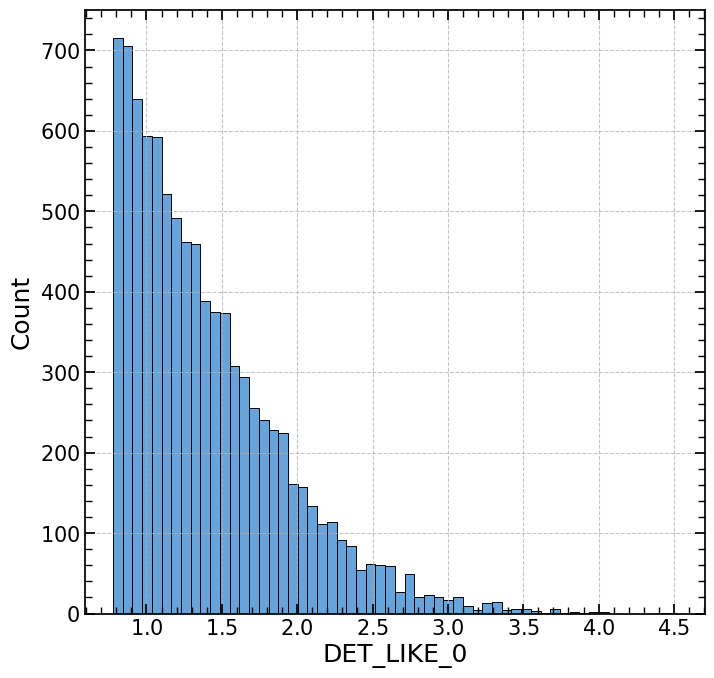

In [21]:
sns.histplot(np.log10(nway_match_res.DET_LIKE_0))

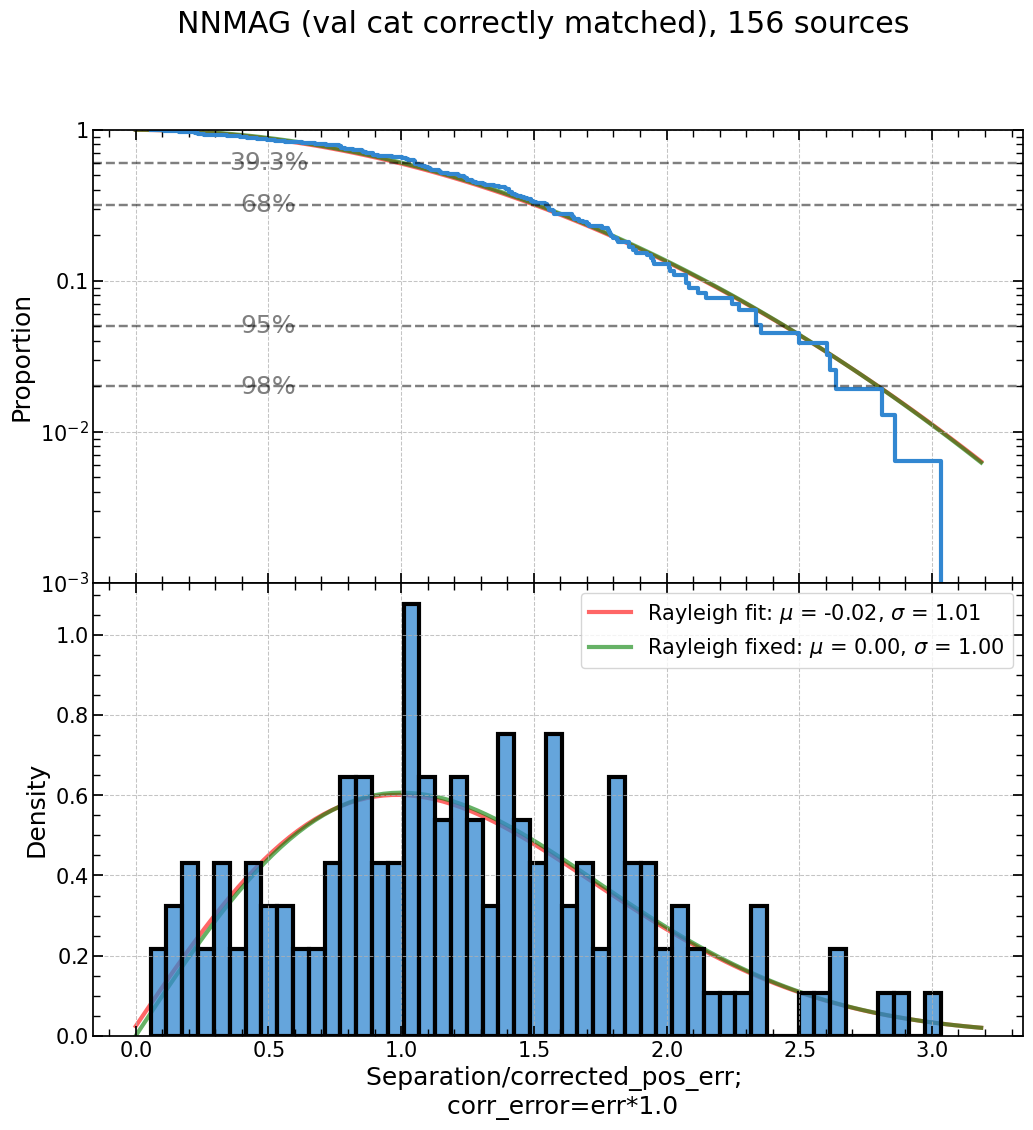

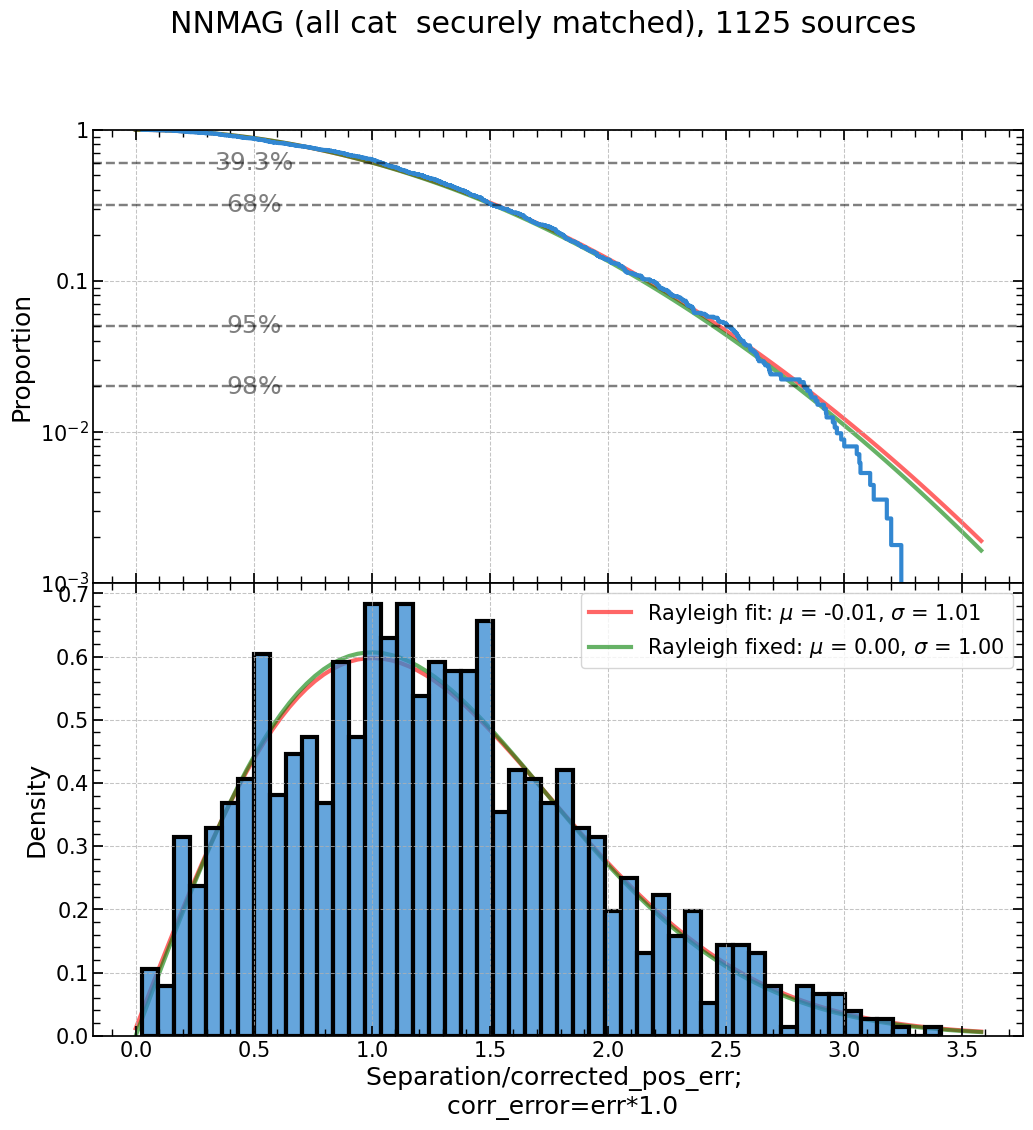

In [22]:

rayleigh_plot(nway_match_res.query('DET_LIKE_0>100 & nway_desi_id==nway_desi_id_true_ctp & nway_desi_id_true_ctp!="hostless"'), sep_col='nway_Separation_EROSITA_DESI', pos_err_col = 'nway_pos_err', plotlabel='NNMAG (val cat correctly matched)')


rayleigh_plot(nway_match_res.query('DET_LIKE_0>100   & nway_prob_has_match > 0.8'), sep_col='nway_Separation_EROSITA_DESI', pos_err_col = 'nway_pos_err', plotlabel='NNMAG (all cat  securely matched)')


# Missing data of the resulting catalogs

In [27]:
cols = ['desi_rel_dered_mag_g', 'desi_rel_dered_mag_r', 'desi_rel_dered_mag_z', 'desi_rel_dered_mag_w1', 'desi_rel_dered_mag_w2', 'desi_rel_dered_mag_w3', 'desi_rel_dered_mag_w4']
print('fraction of missed measurements per filter, in per cent - BEST MATCHES:')
print(nway_match_res[cols].agg(lambda x: np.round(100*np.mean(np.isnan(x)),1)))
print('fraction of missed measurements per filter, in per cent - All within 30 arcsec:')
print(nway_match_res_all[cols].agg(lambda x: np.round(100*np.mean(np.isnan(x)),1)))

fraction of missed measurements per filter, in per cent - BEST MATCHES:
desi_rel_dered_mag_g      7.0
desi_rel_dered_mag_r      4.6
desi_rel_dered_mag_z      1.9
desi_rel_dered_mag_w1     6.7
desi_rel_dered_mag_w2    12.3
desi_rel_dered_mag_w3    72.3
desi_rel_dered_mag_w4    81.3
dtype: float64
fraction of missed measurements per filter, in per cent - All within 30 arcsec:
desi_rel_dered_mag_g     17.5
desi_rel_dered_mag_r     11.5
desi_rel_dered_mag_z      6.5
desi_rel_dered_mag_w1    33.6
desi_rel_dered_mag_w2    55.2
desi_rel_dered_mag_w3    92.8
desi_rel_dered_mag_w4    88.1
dtype: float64


In [28]:
nway_match_res_all

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_desi_id_true_ctp,nway_Separation_EROSITA_DESI,nway_pos_err,nway_prob_has_match,nway_prob_this_match,nway_nnmag_grzw1w2,nway_nnmag_grzw1,nway_nnmag_grz,nway_match_flag,nway_n_match_flag_0,nway_n_match_flag_2,nway_is_closest,nway_is_within_pos_r98,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_all_mag_g,desi_rel_mag_g,desi_rel_dered_mag_g,desi_all_mag_r,desi_rel_mag_r,desi_rel_dered_mag_r,desi_all_mag_z,desi_rel_mag_z,desi_rel_dered_mag_z,desi_all_mag_w1,desi_rel_mag_w1,desi_rel_dered_mag_w1,desi_vega_mag_w1,desi_all_mag_w2,desi_rel_mag_w2,desi_rel_dered_mag_w2,desi_vega_mag_w2,desi_all_mag_w3,desi_rel_mag_w3,desi_rel_dered_mag_w3,desi_vega_mag_w3,desi_all_mag_w4,desi_rel_mag_w4,desi_rel_dered_mag_w4,desi_vega_mag_w4,desi_rel_desi_flux_corr_z,desi_rel_dered_g_r,desi_rel_dered_g_z,desi_rel_dered_r_z,desi_rel_dered_z_w1,desi_rel_dered_r_w2,desi_rel_dered_w1_w2,desi_rel_dered_z_w3,desi_rel_dered_r_w4,desi_rel_dered_w3_w4,desi_lg(Fx/Fo_g),desi_lg(Fx/Fo_r),desi_lg(Fx/Fo_z),desi_rel_dered_lg(Fx/Fo_z),desi_rel_dered_lg(Fx/Fo_z_corr),desi_rel_dered_lg(Fx/Fo_g),desi_rel_dered_lg(Fx/Fo_r),nway_closest_is_psf
20287,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_136,NaN,27.409272,2.982013,0.958140,3.150437e-20,-99.000000,-99.000000,0.307732,0,14,0,False,False,9011,136,606779,154.750219,56.506410,0.218289,0.259747,0.961538,0.669780,3.749257,-2.033533,86.168680,1064.01840,341.324500,68.936470,4.096830,1.032611,0.001391,0.000018,24.056936,23.899303,22.506605,22.929703,21.061779,NaN,17.661356,7.120420,4.798818,7.983458,1.355677,3.809900,-0.075839,0.361240,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.388402,57784.424786,2018-03-17 09:19:17.912,2017-01-31 10:11:41.491,24.152420,24.152420,24.056936,23.963624,23.963624,23.899303,22.542584,22.542584,22.506605,22.935170,NaN,NaN,NaN,21.065137,21.065137,21.061779,17.726137,NaN,NaN,NaN,NaN,17.661626,NaN,NaN,NaN,1.659376e-15,0.157633,1.550331,1.392698,NaN,2.837524,NaN,NaN,NaN,NaN,-13.116117,-13.191636,-13.760052,-13.774444,1.002969,-13.154311,-13.217364,True
20286,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006

In [30]:
print('fraction of missed measurements per filter, in per cent - All within 30 arcsec:')
print(nway_match_res_all.query('nway_Separation_EROSITA_DESI<pos_r98 ')[cols].agg(lambda x: np.round(100*np.mean(np.isnan(x)),1)))
#non-significant sources???

fraction of missed measurements per filter, in per cent - All within 30 arcsec:
desi_rel_dered_mag_g     14.1
desi_rel_dered_mag_r      8.9
desi_rel_dered_mag_z      5.2
desi_rel_dered_mag_w1    20.8
desi_rel_dered_mag_w2    35.0
desi_rel_dered_mag_w3    82.5
desi_rel_dered_mag_w4    82.1
dtype: float64


# Example of a Quasar

desi_id = '9011_606780_1256' is a most probable counterpart of the eROSITA source. 

see image [link](https://www.legacysurvey.org/viewer/?ra=155.3501&dec=56.5357&layer=ls-dr9&zoom=16&spectra)

In [23]:
#nway_match_res.query('nway_desi_id == "9011_606780_1256"')
#nway_match_res.query('srcname_fin == "SRGe J102122.9+563214"').sort_values(['nway_prob_this_match'])
nway_match_res_all.query('srcname_fin == "SRGe J102122.9+563214"').sort_values(by = 'nway_prob_this_match', ascending = False).head(5)[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_r98', 'flux_05-20', 'nway_desi_id', 'nway_desi_id_true_ctp',  'nway_Separation_EROSITA_DESI', 'nway_prob_has_match', 'nway_nnmag_grzw1w2',	'nway_nnmag_grzw1',	'nway_nnmag_grz', 'desi_dered_mag_g', 'desi_dered_mag_r', 'desi_dered_mag_z']]

,srcname_fin,RA_fin,DEC_fin,pos_r98,flux_05-20,nway_desi_id,nway_desi_id_true_ctp,nway_Separation_EROSITA_DESI,nway_prob_has_match,nway_nnmag_grzw1w2,nway_nnmag_grzw1,nway_nnmag_grz,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z
133883,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1256,NaN,16.592597,0.382879,0.966172,0.930407,0.658961,20.402922,19.976002,19.667910
133884,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1202,NaN,1.525698,0.382879,-99.000000,-99.000000,0.119184,23.891247,23.696724,23.387978
133885,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1207,NaN,6.372686,0.382879,-99.000000,-99.000000,-99.000000,24.981260,23.745020,23.064909
133886,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1229,NaN,13.083675,0.382879,-99.000000,-99.000000,0.103030,23.614704,22.644236,22.132998
133887,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1234,NaN,14.940570,0.382879,-99.000000,-99.000000,0.077030,23.926240,23.053194,22.599337



![](../0_data/qso_example.png)


NWAY results for Source 9075:

It is uncertain if this source has a counterpart (p_any=0.38)

Assuming it has a counterpart, we have the following possible associations:

visible_rad=40.000000
Disclaimer: These results assume that the input (sky densities, positional errors, and priors) are correct.



,Separation_EROSITA_DESI,pos_err,match_flag,prob_has_match,prob_this_match,ID,desi_id_true_ctp,desi_id,prior_type,nnmag_grzw1w2,nnmag_grzw1,nnmag_grz
133883,16.592597,5.43819,1,0.382879,0.669097,b'SRGe J102122.9+563214',NaN,b'9011_606780_1256',b'grzw1w2',0.966172,-99.0,-99.000000
133890,1.525698,5.43819,0,0.382879,0.271667,b'SRGe J102122.9+563214',NaN,b'9011_606780_1202',b'grz',-99.000000,-99.0,0.119184
133894,6.372686,5.43819,0,0.382879,0.033727,b'SRGe J102122.9+563214',NaN,b'9011_606780_1207',b'None',-99.000000,-99.0,-99.000000


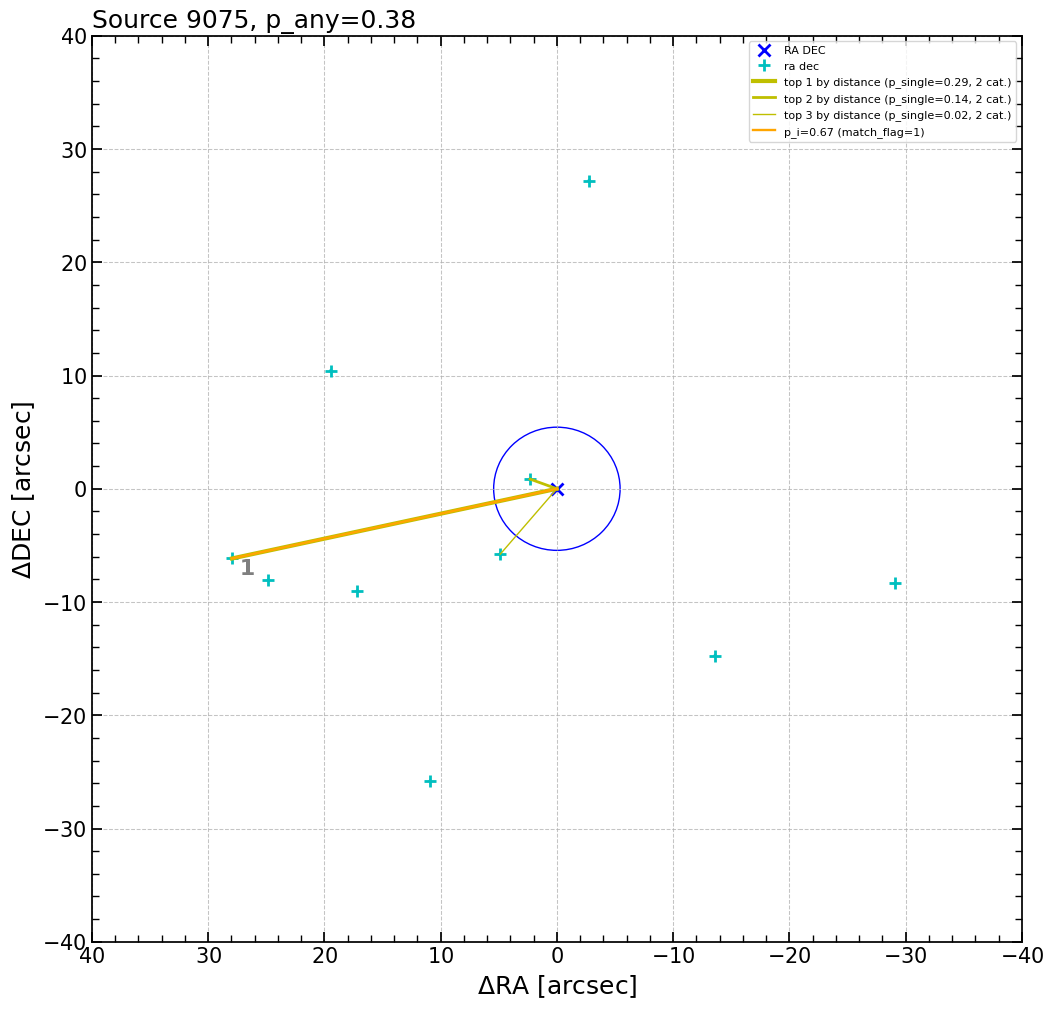

In [24]:
import nway_python_api as nway
test_columns_explain = ['Separation_EROSITA_DESI', 'pos_err',
       'match_flag', 'prob_has_match', 'prob_this_match',
       'ID', 'desi_id_true_ctp', 'desi_id', 'prior_type',
       'nnmag_grzw1w2', 'nnmag_grzw1', 'nnmag_grz', ]
explain_args = {'primary_id_col':'EROSITA', 'cols_ra' : ['RA', 'ra'], 'cols_dec':['DEC', 'dec'], 'cols_err': ['pos_err', 'desi_pos_err'], 'tablenames': ['EROSITA', 'DESI']}
ero_id = nway_res.query("ID == b'SRGe J102122.9+563214'").sort_values(by = 'prob_this_match', ascending = False)['EROSITA'].iloc[0]
nway.explain(nway_res, id = ero_id, visible_rad = 40, **explain_args)[test_columns_explain].head(3)
